## 설치


In [ ]:
pip install -qU langchain umap-learn scikit-learn langchain_community tiktoken langchain-openai langchainhub chromadb langchain-anthropic

# RAPTOR: Recursive Abstractive Processing for Tree-Organized Retrieval

[RAPTOR](https://arxiv.org/pdf/2401.18059.pdf) 논문은 문서의 색인 생성 및 검색에 대한 흥미로운 접근 방식을 제시합니다.

[테디노트 논문 요약글(노션)](https://teddylee777.notion.site/RAPTOR-e835d306fc664dc2ad76191dee1cd859?pvs=4)

- `leafs`는 시작 문서 집합입니다.
- leafs는 임베딩되어 클러스터링됩니다.
- 그런 다음 클러스터는 유사한 문서들 간의 정보를 더 높은 수준(더 추상적인)으로 요약합니다.

이 과정은 재귀적으로 수행되어, 원본 문서(`leafs`)에서 더 추상적인 요약으로 이어지는 "트리"를 형성합니다.

이를 다양한 규모에서 적용할 수 있습니다; `leafs`는 다음과 같을 수 있습니다:

- 단일 문서에서의 텍스트 청크(논문에서 보여준 것처럼)
- 전체 문서(아래에서 보여주는 것처럼)

더 긴 컨텍스트의 LLMs를 사용하면, 전체 문서에 대해 이 작업을 수행할 수 있습니다.


### 문서

LangChain의 LCEL 문서에 이를 적용해 봅시다.

이 경우, 각 `doc`은 LCEL 문서의 고유한 웹 페이지입니다.

콘텍스트는 2,000 토큰 미만에서 10,000 토큰 이상까지 다양합니다.


웹 문서에서 텍스트 데이터를 추출하고, 텍스트의 토큰 수를 계산하여 히스토그램으로 시각화하는 과정을 설명합니다.

- `tiktoken` 라이브러리를 사용하여 주어진 인코딩 이름에 따라 문자열의 토큰 수를 계산합니다.
- `RecursiveUrlLoader` 클래스를 사용하여 지정된 URL에서 웹 문서를 재귀적으로 로드합니다. 이 과정에서 `BeautifulSoup`를 활용하여 HTML 문서에서 텍스트를 추출합니다.
- 여러 URL에서 문서를 로드하여 모든 텍스트 데이터를 하나의 리스트에 모읍니다.
- 각 문서 텍스트에 대해 `num_tokens_from_string` 함수를 호출하여 토큰 수를 계산하고, 이를 리스트에 저장합니다.
- `matplotlib`를 사용하여 계산된 토큰 수의 분포를 히스토그램으로 시각화합니다. 히스토그램은 토큰 수를 x축에, 해당 토큰 수를 가진 문서의 빈도수를 y축에 나타냅니다.
- 히스토그램은 데이터의 분포를 이해하는 데 도움을 주며, 특히 텍스트 데이터의 길이 분포를 시각적으로 파악할 수 있습니다.


<function matplotlib.pyplot.show(close=None, block=None)>

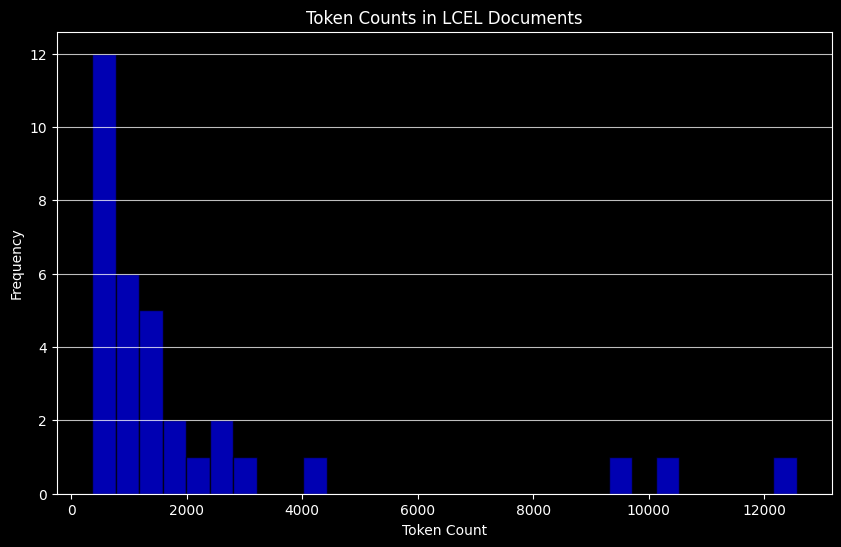

In [2]:
from langchain_community.document_loaders.recursive_url_loader import RecursiveUrlLoader
from bs4 import BeautifulSoup as Soup
import tiktoken
import matplotlib.pyplot as plt


def num_tokens_from_string(string: str, encoding_name: str) -> int:
    # 주어진 문자열에서 토큰의 개수를 반환합니다.
    encoding = tiktoken.get_encoding(encoding_name)
    num_tokens = len(encoding.encode(string))
    return num_tokens


# LCEL 문서 로드
url = "https://python.langchain.com/docs/expression_language/"
loader = RecursiveUrlLoader(
    url=url, max_depth=20, extractor=lambda x: Soup(x, "html.parser").text
)
docs = loader.load()

# PydanticOutputParser를 사용한 LCEL 문서 로드 (기본 LCEL 문서 외부)
url = "https://python.langchain.com/docs/modules/model_io/output_parsers/quick_start"
loader = RecursiveUrlLoader(
    url=url, max_depth=1, extractor=lambda x: Soup(x, "html.parser").text
)
docs_pydantic = loader.load()

# Self Query를 사용한 LCEL 문서 로드 (기본 LCEL 문서 외부)
url = "https://python.langchain.com/docs/modules/data_connection/retrievers/self_query/"
loader = RecursiveUrlLoader(
    url=url, max_depth=1, extractor=lambda x: Soup(x, "html.parser").text
)
docs_sq = loader.load()

# 문서 텍스트
docs.extend([*docs_pydantic, *docs_sq])
docs_texts = [d.page_content for d in docs]

# 각 문서에 대한 토큰 수 계산
counts = [num_tokens_from_string(d, "cl100k_base") for d in docs_texts]

# 토큰 수의 히스토그램을 그립니다.
plt.figure(figsize=(10, 6))
plt.hist(counts, bins=30, color="blue", edgecolor="black", alpha=0.7)
plt.title("Token Counts in LCEL Documents")
plt.xlabel("Token Count")
plt.ylabel("Frequency")
plt.grid(axis="y", alpha=0.75)

# 히스토그램을 표시합니다.
plt.show

문서 텍스트를 정렬하고 연결하여 토큰 수를 계산하는 과정을 설명합니다.

- 문서(`docs`)를 메타데이터의 "source" 키를 기준으로 정렬합니다.
- 정렬된 문서 리스트를 역순으로 뒤집습니다.
- 역순으로 된 문서의 내용을 특정 구분자(`"\n\n\n --- \n\n\n"`)를 사용하여 연결합니다.
- 연결된 내용의 토큰 수를 `num_tokens_from_string` 함수를 사용하여 계산하고, 이를 출력합니다. 이때, `"cl100k_base"` 모델을 사용합니다.


In [3]:
# 문서 텍스트를 연결합니다.
# 문서를 출처 메타데이터 기준으로 정렬합니다.
d_sorted = sorted(docs, key=lambda x: x.metadata["source"])
d_reversed = list(reversed(d_sorted))  # 정렬된 문서를 역순으로 배열합니다.
concatenated_content = "\n\n\n --- \n\n\n".join(
    [
        # 역순으로 배열된 문서의 내용을 연결합니다.
        doc.page_content
        for doc in d_reversed
    ]
)
print(
    "Num tokens in all context: %s"  # 모든 문맥에서의 토큰 수를 출력합니다.
    % num_tokens_from_string(concatenated_content, "cl100k_base")
)

Num tokens in all context: 69074


`RecursiveCharacterTextSplitter`를 사용하여 텍스트를 분할하는 과정을 설명합니다.

- `chunk_size_tok` 변수를 설정하여, 각 텍스트 청크의 크기를 2000 토큰으로 지정합니다.
- `RecursiveCharacterTextSplitter`의 `from_tiktoken_encoder` 메소드를 사용하여 텍스트 분할기를 초기화합니다. 여기서 청크 크기(`chunk_size`)와 청크 간 겹침(`chunk_overlap`)을 0으로 설정합니다.
- 초기화된 텍스트 분할기의 `split_text` 메소드를 호출하여, `concatenated_content`라는 변수에 저장된 연결된 텍스트를 분할합니다. 분할 결과는 `texts_split` 변수에 저장됩니다.


In [4]:
# 텍스트 분할을 위한 코드
from langchain_text_splitters import RecursiveCharacterTextSplitter

chunk_size_tok = 2000  # 토큰의 청크 크기를 설정합니다.
# 재귀적 문자 텍스트 분할기를 초기화합니다. 토큰 인코더를 사용하여 청크 크기와 중복을 설정합니다.
text_splitter = RecursiveCharacterTextSplitter.from_tiktoken_encoder(
    chunk_size=chunk_size_tok, chunk_overlap=0
)
texts_split = text_splitter.split_text(
    concatenated_content
)  # 주어진 텍스트를 분할합니다.

## 모델

다양한 모델을 테스트할 수 있으며, 새로운 [Claude3](https://www.anthropic.com/news/claude-3-family) 계열도 포함됩니다.

관련 API 키를 설정하는 것을 잊지 마세요.

- `OPENAI_API_KEY`, Anthropic 을 사용하는 경우 `ANTHROPIC_API_KEY`


`ChatOpenAI` 혹은 `ChatAnthropic` + `OpenAIEmbeddings`를 사용하여 챗봇 모델을 구현합니다.

- `OpenAIEmbeddings`를 인스턴스화하여 OpenAI의 임베딩 기능을 초기화합니다.
- `ChatOpenAI` 혹은 `ChatAnthropic` 을 사용하여 `temperature`를 0으로 설정하고, 챗봇 모델을 초기화합니다.


In [1]:
from dotenv import load_dotenv

load_dotenv()

True

Cache Embedding 을 사용합니다.


In [70]:
from langchain_openai import OpenAIEmbeddings
from langchain.embeddings import CacheBackedEmbeddings
from langchain.storage import LocalFileStore

store = LocalFileStore("./cache/")

# embeddings 인스턴스를 생성합니다.
embd = OpenAIEmbeddings(model="text-embedding-3-small", disallowed_special=())

cached_embeddings = CacheBackedEmbeddings.from_bytes_store(
    embd, store, namespace=embd.model
)

모델을 초기화 합니다.


In [28]:
from langchain_anthropic import ChatAnthropic
from langchain_openai import OpenAIEmbeddings, ChatOpenAI
from langchain.callbacks.base import BaseCallbackHandler


class StreamCallback(BaseCallbackHandler):
    def on_llm_new_token(self, token: str, **kwargs):
        print(token, end="", flush=True)


# ChatOpenAI 모델을 초기화합니다. 모델은 "gpt-4-turbo-preview"를 사용합니다.
model = ChatOpenAI(
    model="gpt-4-turbo-preview",
    temperature=0,
    streaming=True,
    callbacks=[StreamCallback()],
)

# ChatAnthropic 모델을 초기화합니다. 온도는 0으로 설정하고, 모델은 "claude-3-opus-20240229"를 사용합니다.
# model = ChatAnthropic(temperature=0, model="claude-3-opus-20240229")

### 트리 구축

트리 구축에서의 클러스터링 접근 방식에는 몇 가지 흥미로운 아이디어가 포함되어 있습니다.

**GMM (가우시안 혼합 모델)**

- 다양한 클러스터에 걸쳐 데이터 포인트의 분포를 모델링합니다.
- 모델의 베이지안 정보 기준(BIC)을 평가하여 최적의 클러스터 수를 결정합니다.

**UMAP (Uniform Manifold Approximation and Projection)**

- 클러스터링을 지원합니다.
- 고차원 데이터의 차원을 축소합니다.
- UMAP은 데이터 포인트의 유사성에 기반하여 자연스러운 그룹화를 강조하는 데 도움을 줍니다.

**지역 및 전역 클러스터링**

- 다양한 규모에서 데이터를 분석하는 데 사용됩니다.
- 데이터 내의 세밀한 패턴과 더 넓은 패턴 모두를 효과적으로 포착합니다.

**임계값 설정**

- GMM의 맥락에서 클러스터 멤버십을 결정하기 위해 적용됩니다.
- 확률 분포를 기반으로 합니다(데이터 포인트를 ≥ 1 클러스터에 할당).

---

GMM 및 임계값 설정에 대한 코드는 아래 두 출처에서 언급된 Sarthi et al의 것입니다:

- [원본 저장소](https://github.com/parthsarthi03/raptor/blob/master/raptor/cluster_tree_builder.py)
- [소소한 조정](https://github.com/run-llama/llama_index/blob/main/llama-index-packs/llama-index-packs-raptor/llama_index/packs/raptor/clustering.py)

두 저자 모두에게 전적인 공로를 인정합니다.


`global_cluster_embeddings` 함수는 임베딩의 글로벌 차원 축소를 수행하기 위해 UMAP을 사용합니다.

- 입력된 임베딩(`embeddings`)을 UMAP을 사용하여 지정된 차원(`dim`)으로 차원 축소합니다.
- `n_neighbors`는 각 포인트를 고려할 이웃의 수를 지정하며, 제공되지 않을 경우 임베딩 수의 제곱근으로 기본 설정됩니다.
- `metric`은 UMAP에 사용될 거리 측정 기준을 지정합니다.
- 결과로, 지정된 차원으로 축소된 임베딩이 numpy 배열로 반환됩니다.


In [29]:
from typing import Dict, List, Optional, Tuple

import numpy as np
import pandas as pd
import umap
from langchain.prompts import ChatPromptTemplate
from langchain_core.output_parsers import StrOutputParser
from sklearn.mixture import GaussianMixture

RANDOM_SEED = 42  # 재현성을 위한 고정된 시드 값

### --- 위의 인용된 코드에서 주석과 문서화를 추가함 --- ###


def global_cluster_embeddings(
    embeddings: np.ndarray,
    dim: int,
    n_neighbors: Optional[int] = None,
    metric: str = "cosine",
) -> np.ndarray:
    """
    UMAP을 사용하여 임베딩의 전역 차원 축소를 수행합니다.

    매개변수:
    - embeddings: numpy 배열로 된 입력 임베딩.
    - dim: 축소된 공간의 목표 차원.
    - n_neighbors: 선택 사항; 각 점을 고려할 이웃의 수.
                   제공되지 않으면 임베딩 수의 제곱근으로 기본 설정됩니다.
    - metric: UMAP에 사용할 거리 측정 기준.

    반환값:
    - 지정된 차원으로 축소된 임베딩의 numpy 배열.
    """
    if n_neighbors is None:
        n_neighbors = int((len(embeddings) - 1) ** 0.5)
    return umap.UMAP(
        n_neighbors=n_neighbors, n_components=dim, metric=metric
    ).fit_transform(embeddings)

임베딩 데이터에 대해 지역 차원 축소를 수행하는 함수 `local_cluster_embeddings`를 구현합니다.

- 입력된 임베딩(`embeddings`)을 UMAP을 사용하여 지정된 차원(`dim`)으로 차원 축소합니다.
- 차원 축소 과정에서 각 점에 대해 고려할 이웃의 수(`num_neighbors`)와 거리 측정 메트릭(`metric`)을 파라미터로 사용합니다.
- 최종적으로 차원이 축소된 임베딩을 `numpy` 배열로 반환합니다.


In [30]:
def local_cluster_embeddings(
    embeddings: np.ndarray, dim: int, num_neighbors: int = 10, metric: str = "cosine"
) -> np.ndarray:
    """
    임베딩에 대해 지역 차원 축소를 수행합니다. 이는 일반적으로 전역 클러스터링 이후에 사용됩니다.

    매개변수:
    - embeddings: numpy 배열로서의 입력 임베딩.
    - dim: 축소된 공간의 목표 차원 수.
    - num_neighbors: 각 점에 대해 고려할 이웃의 수.
    - metric: UMAP에 사용할 거리 측정 기준.

    반환값:
    - 지정된 차원으로 축소된 임베딩의 numpy 배열.
    """
    return umap.UMAP(
        n_neighbors=num_neighbors, n_components=dim, metric=metric
    ).fit_transform(embeddings)

`get_optimal_clusters` 함수는 주어진 임베딩 데이터를 기반으로 최적의 클러스터 수를 결정하는 데 사용됩니다. 이 과정은 가우시안 혼합 모델(Gaussian Mixture Model)을 사용하여 베이지안 정보 기준(Bayesian Information Criterion, BIC)을 계산함으로써 수행됩니다.

- 입력 임베딩(`embeddings`)은 numpy 배열로 제공됩니다.
- 최대 클러스터 수(`max_clusters`)는 고려할 클러스터의 최대 수를 지정합니다. 기본값은 50입니다.
- 재현성을 위한 난수 상태(`random_state`)는 고정된 값을 사용합니다.
- 함수는 입력 임베딩에 대해 여러 클러스터 수를 시도하며 각각에 대한 BIC 값을 계산합니다.
- 최소 BIC 값을 가지는 클러스터 수를 최적의 클러스터 수로 결정하고 반환합니다.

이 함수는 클러스터링 문제에서 데이터를 가장 잘 설명하는 클러스터 수를 자동으로 찾는 데 유용하게 사용될 수 있습니다.


In [31]:
def get_optimal_clusters(
    embeddings: np.ndarray, max_clusters: int = 50, random_state: int = RANDOM_SEED
) -> int:
    """
    가우시안 혼합 모델(Gaussian Mixture Model)을 사용하여 베이지안 정보 기준(BIC)을 통해 최적의 클러스터 수를 결정합니다.

    매개변수:
    - embeddings: numpy 배열로서의 입력 임베딩.
    - max_clusters: 고려할 최대 클러스터 수.
    - random_state: 재현성을 위한 시드.

    반환값:
    - 발견된 최적의 클러스터 수를 나타내는 정수.
    """
    max_clusters = min(
        max_clusters, len(embeddings)
    )  # 최대 클러스터 수와 임베딩의 길이 중 작은 값을 최대 클러스터 수로 설정
    n_clusters = np.arange(1, max_clusters)  # 1부터 최대 클러스터 수까지의 범위를 생성
    bics = []  # BIC 점수를 저장할 리스트
    for n in n_clusters:  # 각 클러스터 수에 대해 반복
        gm = GaussianMixture(
            n_components=n, random_state=random_state
        )  # 가우시안 혼합 모델 초기화
        gm.fit(embeddings)  # 임베딩에 대해 모델 학습
        bics.append(gm.bic(embeddings))  # 학습된 모델의 BIC 점수를 리스트에 추가
    return n_clusters[np.argmin(bics)]  # BIC 점수가 가장 낮은 클러스터 수를 반환

`GMM_cluster` 함수는 임베딩을 가우시안 혼합 모델(Gaussian Mixture Model, GMM)을 사용하여 클러스터링합니다. 이 과정은 확률 임계값을 기반으로 합니다.

- 입력된 임베딩(`embeddings`)은 numpy 배열로 제공됩니다.
- `threshold`는 임베딩을 특정 클러스터에 할당하기 위한 확률 임계값입니다.
- `random_state`는 결과의 재현성을 위한 시드 값입니다.
- 최적의 클러스터 수를 결정하기 위해 `get_optimal_clusters` 함수를 호출합니다.
- 결정된 클러스터 수를 바탕으로 가우시안 혼합 모델을 초기화하고, 입력된 임베딩에 대해 학습을 수행합니다.
- 각 임베딩에 대한 클러스터 할당 확률을 계산하고, 이 확률이 주어진 임계값을 초과하는 경우 해당 임베딩을 클러스터에 할당합니다.
- 함수는 최종적으로 임베딩의 클러스터 레이블과 결정된 클러스터 수를 튜플로 반환합니다.


In [32]:
def GMM_cluster(embeddings: np.ndarray, threshold: float, random_state: int = 0):
    """
    확률 임계값을 기반으로 가우시안 혼합 모델(GMM)을 사용하여 임베딩을 클러스터링합니다.

    매개변수:
    - embeddings: numpy 배열로서의 입력 임베딩.
    - threshold: 임베딩을 클러스터에 할당하기 위한 확률 임계값.
    - random_state: 재현성을 위한 시드.

    반환값:
    - 클러스터 레이블과 결정된 클러스터 수를 포함하는 튜플.
    """
    n_clusters = get_optimal_clusters(embeddings)  # 최적의 클러스터 수를 구합니다.
    # 가우시안 혼합 모델을 초기화합니다.
    gm = GaussianMixture(n_components=n_clusters, random_state=random_state)
    gm.fit(embeddings)  # 임베딩에 대해 모델을 학습합니다.
    probs = gm.predict_proba(
        embeddings
    )  # 임베딩이 각 클러스터에 속할 확률을 예측합니다.
    # 임계값을 초과하는 확률을 가진 클러스터를 레이블로 선택합니다.
    labels = [np.where(prob > threshold)[0] for prob in probs]
    return labels, n_clusters  # 레이블과 클러스터 수를 반환합니다.

`perform_clustering` 함수는 임베딩에 대해 차원 축소, 가우시안 혼합 모델을 사용한 글로벌 클러스터링, 그리고 각 글로벌 클러스터 내에서의 로컬 클러스터링을 수행하여 클러스터링 결과를 반환합니다.

- 입력된 임베딩(`embeddings`)에 대해 차원 축소를 수행합니다. 이는 UMAP을 사용하여 지정된 차원(`dim`)으로 임베딩의 차원을 축소하는 과정을 포함합니다.
- 차원이 축소된 임베딩에 대해 가우시안 혼합 모델(GMM)을 사용하여 글로벌 클러스터링을 수행합니다. 클러스터 할당은 주어진 확률 임계값(`threshold`)을 기준으로 결정됩니다.
- 각 글로벌 클러스터 내에서 추가적인 로컬 클러스터링을 수행합니다. 이 과정은 글로벌 클러스터링 결과를 바탕으로 각 글로벌 클러스터에 속한 임베딩들만을 대상으로 다시 차원 축소 및 GMM 클러스터링을 진행합니다.
- 최종적으로, 모든 임베딩에 대해 글로벌 및 로컬 클러스터 ID를 할당하여, 각 임베딩이 속한 클러스터 ID를 담은 리스트를 반환합니다. 이 리스트는 임베딩의 순서에 따라 각 임베딩에 대한 클러스터 ID 배열을 포함합니다.

이 함수는 고차원 데이터의 클러스터링을 위해 글로벌 및 로컬 차원에서의 클러스터링을 결합한 접근 방식을 제공합니다. 이를 통해 더 세분화된 클러스터링 결과를 얻을 수 있으며, 복잡한 데이터 구조를 보다 효과적으로 분석할 수 있습니다.


In [33]:
def perform_clustering(
    embeddings: np.ndarray,
    dim: int,
    threshold: float,
) -> List[np.ndarray]:
    """
    임베딩에 대해 차원 축소, 가우시안 혼합 모델을 사용한 클러스터링, 각 글로벌 클러스터 내에서의 로컬 클러스터링을 순서대로 수행합니다.

    매개변수:
    - embeddings: numpy 배열로 된 입력 임베딩입니다.
    - dim: UMAP 축소를 위한 목표 차원입니다.
    - threshold: GMM에서 임베딩을 클러스터에 할당하기 위한 확률 임계값입니다.

    반환값:
    - 각 임베딩의 클러스터 ID를 포함하는 numpy 배열의 리스트입니다.
    """
    if len(embeddings) <= dim + 1:
        # 데이터가 충분하지 않을 때 클러스터링을 피합니다.
        return [np.array([0]) for _ in range(len(embeddings))]

    # 글로벌 차원 축소
    reduced_embeddings_global = global_cluster_embeddings(embeddings, dim)
    # 글로벌 클러스터링
    global_clusters, n_global_clusters = GMM_cluster(
        reduced_embeddings_global, threshold
    )

    all_local_clusters = [np.array([]) for _ in range(len(embeddings))]
    total_clusters = 0

    # 각 글로벌 클러스터를 순회하며 로컬 클러스터링 수행
    for i in range(n_global_clusters):
        # 현재 글로벌 클러스터에 속하는 임베딩 추출
        global_cluster_embeddings_ = embeddings[
            np.array([i in gc for gc in global_clusters])
        ]

        if len(global_cluster_embeddings_) == 0:
            continue
        if len(global_cluster_embeddings_) <= dim + 1:
            # 작은 클러스터는 직접 할당으로 처리
            local_clusters = [np.array([0]) for _ in global_cluster_embeddings_]
            n_local_clusters = 1
        else:
            # 로컬 차원 축소 및 클러스터링
            reduced_embeddings_local = local_cluster_embeddings(
                global_cluster_embeddings_, dim
            )
            local_clusters, n_local_clusters = GMM_cluster(
                reduced_embeddings_local, threshold
            )

        # 로컬 클러스터 ID 할당, 이미 처리된 총 클러스터 수를 조정
        for j in range(n_local_clusters):
            local_cluster_embeddings_ = global_cluster_embeddings_[
                np.array([j in lc for lc in local_clusters])
            ]
            indices = np.where(
                (embeddings == local_cluster_embeddings_[:, None]).all(-1)
            )[1]
            for idx in indices:
                all_local_clusters[idx] = np.append(
                    all_local_clusters[idx], j + total_clusters
                )

        total_clusters += n_local_clusters

    return all_local_clusters

텍스트 문서의 목록에 대한 임베딩을 생성하는 함수 `embed`를 구현합니다.

- 입력으로 텍스트 문서의 목록(`texts`)을 받습니다.
- `embd` 객체의 `embed_documents` 메소드를 사용하여 텍스트 문서의 임베딩을 생성합니다.
- 생성된 임베딩을 `numpy.ndarray` 형태로 변환하여 반환합니다.


In [34]:
def embed(texts):
    # 텍스트 문서 목록에 대한 임베딩을 생성합니다.
    #
    # 이 함수는 `embd` 객체가 존재한다고 가정하며, 이 객체는 텍스트 목록을 받아 그 임베딩을 반환하는 `embed_documents` 메소드를 가지고 있습니다.
    #
    # 매개변수:
    # - texts: List[str], 임베딩할 텍스트 문서의 목록입니다.
    #
    # 반환값:
    # - numpy.ndarray: 주어진 텍스트 문서들에 대한 임베딩 배열입니다.
    text_embeddings = embd.embed_documents(
        texts
    )  # 텍스트 문서들의 임베딩을 생성합니다.
    text_embeddings_np = np.array(text_embeddings)  # 임베딩을 numpy 배열로 변환합니다.
    return text_embeddings_np  # 임베딩된 numpy 배열을 반환합니다.

`embed_cluster_texts` 함수는 텍스트 목록을 임베딩하고 클러스터링하여, 원본 텍스트, 해당 임베딩, 그리고 할당된 클러스터 라벨을 포함하는 `pandas.DataFrame`을 반환합니다.

- 주어진 텍스트 목록에 대해 임베딩을 생성합니다.
- 생성된 임베딩을 기반으로 클러스터링을 수행합니다. 이 과정은 사전에 정의된 `perform_clustering` 함수를 사용합니다.
- 결과를 저장하기 위해 `pandas.DataFrame`을 초기화합니다.
- DataFrame에 원본 텍스트, 임베딩 리스트, 클러스터 라벨을 각각 저장합니다.

이 함수는 텍스트 데이터의 임베딩 생성과 클러스터링을 하나의 단계로 결합하여, 텍스트 데이터의 구조적 분석과 그룹화를 용이하게 합니다.


In [35]:
def embed_cluster_texts(texts):
    """
    텍스트 목록을 임베딩하고 클러스터링하여, 텍스트, 그들의 임베딩, 그리고 클러스터 라벨이 포함된 DataFrame을 반환합니다.

    이 함수는 임베딩 생성과 클러스터링을 단일 단계로 결합합니다. 임베딩에 대해 클러스터링을 수행하는 `perform_clustering` 함수의 사전 정의된 존재를 가정합니다.

    매개변수:
    - texts: List[str], 처리될 텍스트 문서의 목록입니다.

    반환값:
    - pandas.DataFrame: 원본 텍스트, 그들의 임베딩, 그리고 할당된 클러스터 라벨이 포함된 DataFrame입니다.
    """
    text_embeddings_np = embed(texts)  # 임베딩 생성
    cluster_labels = perform_clustering(
        text_embeddings_np, 10, 0.1
    )  # 임베딩에 대해 클러스터링 수행
    df = pd.DataFrame()  # 결과를 저장할 DataFrame 초기화
    df["text"] = texts  # 원본 텍스트 저장
    df["embd"] = list(text_embeddings_np)  # DataFrame에 리스트로 임베딩 저장
    df["cluster"] = cluster_labels  # 클러스터 라벨 저장
    return df

`fmt_txt` 함수는 `pandas`의 `DataFrame`에서 텍스트 문서를 단일 문자열로 포맷팅합니다.

- 입력 파라미터로 `DataFrame`을 받으며, 이 `DataFrame`은 포맷팅할 텍스트 문서를 포함한 'text' 컬럼을 가져야 합니다.
- 모든 텍스트 문서는 특정 구분자("--- --- \n --- ---")를 사용하여 연결되어 단일 문자열로 반환됩니다.
- 함수는 연결된 텍스트 문서를 포함하는 단일 문자열을 반환합니다.


In [36]:
def fmt_txt(df: pd.DataFrame) -> str:
    """
    DataFrame에 있는 텍스트 문서를 단일 문자열로 포맷합니다.

    매개변수:
    - df: 'text' 열에 포맷할 텍스트 문서가 포함된 DataFrame.

    반환값:
    - 모든 텍스트 문서가 특정 구분자로 결합된 단일 문자열.
    """
    unique_txt = df["text"].tolist()  # 'text' 열의 모든 텍스트를 리스트로 변환
    return "--- --- \n --- --- ".join(
        unique_txt
    )  # 텍스트 문서들을 특정 구분자로 결합하여 반환

텍스트 데이터를 임베딩하고, 클러스터링하며, 각 클러스터에 대한 요약을 생성하는 과정을 수행합니다.

- 주어진 텍스트 목록에 대해 임베딩을 생성하고 유사성에 기반한 클러스터링을 진행합니다. 이 과정은 `df_clusters` 데이터프레임을 결과로 합니다. 이 데이터프레임에는 원본 텍스트, 임베딩, 그리고 클러스터 할당 정보가 포함됩니다.
- 클러스터 할당을 쉽게 처리하기 위해 데이터프레임 항목을 확장합니다. 각 행은 텍스트, 임베딩, 클러스터를 포함하는 새로운 데이터프레임으로 변환됩니다.
- 확장된 데이터프레임에서 고유한 클러스터 식별자를 추출하고, 각 클러스터에 대한 텍스트를 포맷팅하여 요약을 생성합니다. 이 요약은 `df_summary` 데이터프레임에 저장됩니다. 이 데이터프레임은 각 클러스터의 요약, 지정된 세부 수준, 그리고 클러스터 식별자를 포함합니다.
- 최종적으로, 함수는 두 개의 데이터프레임을 포함하는 튜플을 반환합니다. 첫 번째 데이터프레임은 원본 텍스트, 임베딩, 클러스터 할당 정보를 포함하며, 두 번째 데이터프레임은 각 클러스터에 대한 요약과 해당 세부 수준, 클러스터 식별자를 포함합니다.


In [37]:
def embed_cluster_summarize_texts(
    texts: List[str], level: int
) -> Tuple[pd.DataFrame, pd.DataFrame]:
    """
    텍스트 목록에 대해 임베딩, 클러스터링 및 요약을 수행합니다. 이 함수는 먼저 텍스트에 대한 임베딩을 생성하고,
    유사성을 기반으로 클러스터링을 수행한 다음, 클러스터 할당을 확장하여 처리를 용이하게 하고 각 클러스터 내의 내용을 요약합니다.

    매개변수:
    - texts: 처리할 텍스트 문서 목록입니다.
    - level: 처리의 깊이나 세부 사항을 정의할 수 있는 정수 매개변수입니다.

    반환값:
    - 두 개의 데이터프레임을 포함하는 튜플:
      1. 첫 번째 데이터프레임(`df_clusters`)은 원본 텍스트, 그들의 임베딩, 그리고 클러스터 할당을 포함합니다.
      2. 두 번째 데이터프레임(`df_summary`)은 각 클러스터에 대한 요약, 지정된 세부 수준, 그리고 클러스터 식별자를 포함합니다.
    """

    # 텍스트를 임베딩하고 클러스터링하여 'text', 'embd', 'cluster' 열이 있는 데이터프레임을 생성합니다.
    df_clusters = embed_cluster_texts(texts)

    # 클러스터를 쉽게 조작하기 위해 데이터프레임을 확장할 준비를 합니다.
    expanded_list = []

    # 데이터프레임 항목을 문서-클러스터 쌍으로 확장하여 처리를 간단하게 합니다.
    for index, row in df_clusters.iterrows():
        for cluster in row["cluster"]:
            expanded_list.append(
                {"text": row["text"], "embd": row["embd"], "cluster": cluster}
            )

    # 확장된 목록에서 새 데이터프레임을 생성합니다.
    expanded_df = pd.DataFrame(expanded_list)

    # 처리를 위해 고유한 클러스터 식별자를 검색합니다.
    all_clusters = expanded_df["cluster"].unique()

    print(f"--Generated {len(all_clusters)} clusters--")

    # 요약
    template = """여기 LangChain 표현 언어 문서의 하위 집합이 있습니다.
    
    LangChain 표현 언어는 LangChain에서 체인을 구성하는 방법을 제공합니다.
    
    제공된 문서의 자세한 요약을 제공하십시오.
    
    문서:
    {context}
    """
    prompt = ChatPromptTemplate.from_template(template)
    chain = prompt | model | StrOutputParser()

    # 각 클러스터 내의 텍스트를 요약을 위해 포맷팅합니다.
    summaries = []
    for i in all_clusters:
        df_cluster = expanded_df[expanded_df["cluster"] == i]
        formatted_txt = fmt_txt(df_cluster)
        summaries.append(chain.invoke({"context": formatted_txt}))

    # 요약, 해당 클러스터 및 레벨을 저장할 데이터프레임을 생성합니다.
    df_summary = pd.DataFrame(
        {
            "summaries": summaries,
            "level": [level] * len(summaries),
            "cluster": list(all_clusters),
        }
    )

    return df_clusters, df_summary

텍스트 데이터를 재귀적으로 임베딩, 클러스터링 및 요약하는 과정을 구현한 함수입니다.

- 주어진 텍스트 리스트를 임베딩, 클러스터링 및 요약하여 각 단계별로 결과를 저장합니다.
- 함수는 최대 지정된 재귀 레벨까지 실행되거나, 유일한 클러스터의 수가 1이 될 때까지 반복됩니다.
- 각 재귀 단계에서는 현재 레벨의 클러스터링 결과와 요약 결과를 데이터프레임 형태로 반환하고, 이를 결과 딕셔너리에 저장합니다.
- 만약 현재 레벨이 최대 재귀 레벨보다 작고, 유일한 클러스터의 수가 1보다 크다면, 현재 레벨의 요약 결과를 다음 레벨의 입력 텍스트로 사용하여 재귀적으로 함수를 호출합니다.
- 최종적으로 각 레벨별 클러스터 데이터프레임과 요약 데이터프레임을 포함하는 딕셔너리를 반환합니다.


In [38]:
def recursive_embed_cluster_summarize(
    texts: List[str], level: int = 1, n_levels: int = 3
) -> Dict[int, Tuple[pd.DataFrame, pd.DataFrame]]:
    """
    지정된 레벨까지 또는 고유 클러스터의 수가 1이 될 때까지 텍스트를 재귀적으로 임베딩, 클러스터링, 요약하여
    각 레벨에서의 결과를 저장합니다.

    매개변수:
    - texts: List[str], 처리할 텍스트들.
    - level: int, 현재 재귀 레벨 (1에서 시작).
    - n_levels: int, 재귀의 최대 깊이.

    반환값:
    - Dict[int, Tuple[pd.DataFrame, pd.DataFrame]], 재귀 레벨을 키로 하고 해당 레벨에서의 클러스터 DataFrame과 요약 DataFrame을 포함하는 튜플을 값으로 하는 사전.
    """
    results = {}  # 각 레벨에서의 결과를 저장할 사전

    # 현재 레벨에 대해 임베딩, 클러스터링, 요약 수행
    df_clusters, df_summary = embed_cluster_summarize_texts(texts, level)

    # 현재 레벨의 결과 저장
    results[level] = (df_clusters, df_summary)

    # 추가 재귀가 가능하고 의미가 있는지 결정
    unique_clusters = df_summary["cluster"].nunique()
    if level < n_levels and unique_clusters > 1:
        # 다음 레벨의 재귀 입력 텍스트로 요약 사용
        new_texts = df_summary["summaries"].tolist()
        next_level_results = recursive_embed_cluster_summarize(
            new_texts, level + 1, n_levels
        )

        # 다음 레벨의 결과를 현재 결과 사전에 병합
        results.update(next_level_results)

    return results

In [82]:
# 전체 문서의 개수
len(docs_texts)

33

In [39]:
# 트리 구축
leaf_texts = docs_texts  # 문서 텍스트를 리프 텍스트로 설정
results = recursive_embed_cluster_summarize(
    leaf_texts, level=1, n_levels=3
)  # 재귀적으로 임베딩, 클러스터링 및 요약을 수행하여 결과를 얻음

--Generated 6 clusters--
LangChain Expression Language (LCEL)는 LangChain에서 체인을 구성하는 선언적 방법을 제공합니다. LCEL은 프로토타입을 생산에 투입하는 것을 지원하도록 설계되었으며, 가장 간단한 "프롬프트 + LLM" 체인부터 수백 단계의 복잡한 체인까지 코드 변경 없이 생산에서 성공적으로 실행할 수 있습니다. LCEL을 사용하는 몇 가지 이유는 다음과 같습니다:

- **스트리밍 지원**: LCEL로 체인을 구축하면 최상의 첫 번째 토큰까지의 시간을 얻을 수 있습니다. 이는 일부 체인에서 LLM에서 스트리밍 출력 파서로 토큰을 직접 스트리밍하고, LLM 제공자가 원시 토큰을 출력하는 속도로 파싱된 증분 출력 청크를 받을 수 있음을 의미합니다.
- **비동기 지원**: LCEL로 구축된 모든 체인은 동기 API(예: 프로토타이핑 중인 Jupyter 노트북에서)와 비동기 API(예: LangServe 서버에서) 모두에서 호출할 수 있습니다. 이를 통해 프로토타입과 생산에서 동일한 코드를 사용하고, 뛰어난 성능을 제공하며, 동일한 서버에서 많은 동시 요청을 처리할 수 있습니다.
- **최적화된 병렬 실행**: LCEL 체인에 병렬로 실행할 수 있는 단계가 있는 경우(예: 여러 검색기에서 문서를 가져올 때), 동기 및 비동기 인터페이스 모두에서 자동으로 수행하여 가능한 가장 작은 대기 시간을 제공합니다.
- **재시도 및 대체**: LCEL 체인의 모든 부분에 대해 재시도 및 대체를 구성할 수 있습니다. 이는 규모에서 체인을 더욱 신뢰할 수 있게 만드는 좋은 방법입니다.
- **중간 결과 접근**: 더 복잡한 체인의 경우 최종 출력이 생성되기 전에 중간 단계의 결과에 액세스하는 것이 매우 유용할 수 있습니다. 이를 통해 최종 사용자에게 무언가가 진행되고 있음을 알리거나 체인을 디버깅할 수 있습니다.
- **입력 및 출력 스키마**: 입력 및 출력 스키마는 체인의 구조로부터 추론된 Pydantic 및 J

논문에서는 `collapsed tree retrieval`이 최고의 성능을 보고하고 있습니다.

이는 트리 구조를 단일 계층으로 평탄화한 다음, 모든 노드에 대해 동시에 k-최근접 이웃(kNN) 검색을 적용하는 과정을 포함합니다.

아래에서 이 과정을 간단히 수행합니다.


`Chroma` 벡터 저장소를 사용하여 텍스트 데이터의 벡터화 및 검색 가능한 저장소를 구축하는 과정을 설명합니다.

- 초기에 `leaf_texts`에 저장된 텍스트 데이터를 `all_texts` 변수에 복사합니다.
- 결과 데이터(`results`)를 순회하며 각 레벨에서 요약된 텍스트를 추출하고, 이를 `all_texts`에 추가합니다.
  - 각 레벨의 `DataFrame`에서 `summaries` 컬럼의 값을 리스트로 변환하여 추출합니다.
  - 추출된 요약문을 `all_texts`에 추가합니다.
- 모든 텍스트 데이터(`all_texts`)를 사용하여 `Chroma` 벡터 저장소를 구축합니다.
  - `Chroma.from_texts` 함수를 호출하여 텍스트 데이터를 벡터화하고, 벡터 저장소를 생성합니다.
  - 생성된 벡터 저장소를 검색 가능하게 만들기 위해 `.as_retriever()` 메소드를 사용하여 검색기(retriever)를 초기화합니다.

이 과정을 통해, 다양한 레벨의 요약문을 포함한 텍스트 데이터를 벡터화하고, 이를 기반으로 검색 가능한 `Chroma` 벡터 저장소를 구축합니다.


In [64]:
from langchain_community.vectorstores import FAISS

# leaf_texts를 복사하여 all_texts를 초기화합니다.
all_texts = leaf_texts.copy()

# 각 레벨의 요약을 추출하여 all_texts에 추가하기 위해 결과를 순회합니다.
for level in sorted(results.keys()):
    # 현재 레벨의 DataFrame에서 요약을 추출합니다.
    summaries = results[level][1]["summaries"].tolist()
    # 현재 레벨의 요약을 all_texts에 추가합니다.
    all_texts.extend(summaries)

# 이제 all_texts를 사용하여 FAISS vectorstore를 구축합니다.
vectorstore = FAISS.from_texts(texts=all_texts, embedding=embd)

DB 를 로컬에 저장합니다.


In [66]:
import os

DB_INDEX = "RAPTOR"

# 로컬에 FAISS DB 인덱스가 이미 존재하는지 확인하고, 그렇다면 로드하여 vectorstore와 병합한 후 저장합니다.
if os.path.exists(DB_INDEX):
    local_index = FAISS.load_local(DB_INDEX, embd)
    local_index.merge_from(vectorstore)
    local_index.save_local(DB_INDEX)
else:
    vectorstore.save_local(folder_path=DB_INDEX)

In [67]:
# retriever 생성
retriever = vectorstore.as_retriever()

Retrieval Augmented Generation(RAG) 체인을 정의하고 특정 코드 예제를 요청하는 방법을 구현합니다.

- `hub.pull`을 사용하여 RAG 프롬프트를 불러옵니다.
- 문서 포맷팅을 위한 `format_docs` 함수를 정의합니다. 이 함수는 문서의 페이지 내용을 연결하여 반환합니다.
- RAG 체인을 구성합니다. 이 체인은 검색기(`retriever`)로부터 문맥을 가져오고, `format_docs` 함수로 포맷팅한 후, 질문을 처리합니다.
- `RunnablePassthrough()`를 사용하여 질문을 그대로 전달합니다.
- 체인은 프롬프트, 모델, 그리고 `StrOutputParser()`를 통해 최종 출력을 문자열로 파싱합니다.
- `rag_chain.invoke` 메소드를 사용하여 "How to define a RAG chain? Give me a specific code example."라는 질문을 처리합니다.


In [73]:
from langchain import hub
from langchain_core.runnables import RunnablePassthrough

# 프롬프트 생성
prompt = hub.pull("rlm/rag-prompt")

# 문서 포스트 프로세싱


def format_docs(docs):
    # 문서의 페이지 내용을 이어붙여 반환합니다.
    return "\n\n".join(doc.page_content for doc in docs)


# RAG 체인 정의
rag_chain = (
    # 검색 결과를 포맷팅하고 질문을 처리합니다.
    {"context": retriever | format_docs, "question": RunnablePassthrough()}
    | prompt  # 프롬프트를 적용합니다.
    | model  # 모델을 적용합니다.
    | StrOutputParser()  # 문자열 출력 파서를 적용합니다.
)

[LangSmith 링크](https://smith.langchain.com/public/178afde0-8dcc-472f-8c47-233fe81cbbad/r)


In [83]:
# 추상적인 질문 실행
_ = rag_chain.invoke("전체 문서의 핵심 주제에 대해 설명해주세요.")

LangChain 표현 언어(LCEL) 문서는 LangChain을 사용하여 복잡한 데이터 처리 및 변환 파이프라인을 구축하는 방법에 대한 가이드와 예시를 제공합니다. 이 문서는 다양한 Runnable 타입, 런타임 인자 바인딩, 체인 내부 구성, `@chain` 데코레이터 사용, Fallback 추가, 커스텀 제너레이터 함수 스트리밍 등 LCEL의 핵심 기능과 사용 방법을 설명합니다. 또한, LCEL을 사용하여 프롬프트와 LLM을 결합하는 방법, 검색 단계 추가, 여러 체인 연결, SQL DB 쿼리, 코드 작성, 의미적 유사성에 따른 라우팅, 메모리 추가, 검열 추가 등 다양한 작업을 수행하는 방법을 단계별로 제공합니다.

[LangSmith 링크](https://smith.langchain.com/public/1d72738b-f378-4676-9961-dd12fe424918/r)


In [84]:
# Low Level 질문 실행
_ = rag_chain.invoke("PydanticOutputParser 을 활용한 예시 코드를 작성해 주세요.")

```python
from langchain.output_parsers import PydanticOutputParser
from langchain.prompts import PromptTemplate
from langchain_core.pydantic_v1 import BaseModel, Field, validator
from langchain_openai import OpenAI

model = OpenAI(model_name="gpt-3.5-turbo-instruct", temperature=0.0)

class Joke(BaseModel):
    setup: str = Field(description="question to set up a joke")
    punchline: str = Field(description="answer to resolve the joke")
    @validator("setup")
    def question_ends_with_question_mark(cls, field):
        if field[-1] != "?":
            raise ValueError("Badly formed question!")
        return field

parser = PydanticOutputParser(pydantic_object=Joke)
prompt = PromptTemplate(
    template="Answer the user query.\n{format_instructions}\n{query}\n",
    input_variables=["query"],
    partial_variables={"format_instructions": parser.get_format_instructions()},
)

prompt_and_model = prompt | model
output = prompt_and_model.invoke({"query": "Tell me a joke."})
parser.invo

[LangSmith 링크](https://smith.langchain.com/public/bd725efb-d854-4d0e-b34b-52748dddcf4b/r)


In [85]:
# Low Level 질문 실행
_ = rag_chain.invoke("self-querying 방법과 예시 코드를 작성해 주세요.")

Self-querying 방법은 자연어 쿼리를 받아 구조화된 쿼리를 작성하고, 이를 기반으로 VectorStore에 적용하여 문서의 의미적 유사성 비교 및 사용자 쿼리에서 추출한 필터를 메타데이터에 적용하여 실행하는 방식입니다. 예를 들어, Chroma vector store를 사용하여 영화 요약 문서가 포함된 작은 데모 세트를 생성하고, 이를 통해 자체 쿼리 검색기를 인스턴스화할 수 있습니다. 다음은 자체 쿼리 검색기를 사용하는 예시 코드입니다:

```python
%pip install --upgrade --quiet  lark chromadb
from langchain_community.vectorstores import Chroma
from langchain_core.documents import Document
from langchain_openai import OpenAIEmbeddings

docs = [
    Document(
        page_content="A bunch of scientists bring back dinosaurs and mayhem breaks loose",
        metadata={"year": 1993, "rating": 7.7, "genre": "science fiction"},
    ),
    # Additional documents...
]

vectorstore = Chroma.from_documents(docs, OpenAIEmbeddings())

from langchain.chains.query_constructor.base import AttributeInfo
from langchain.retrievers.self_query.base import SelfQueryRetriever
from langchain_openai import ChatOpenAI

metadata_field_info = [
    AttributeInfo(
        name="genre",
        desc